# Notebook for the Kaggle Titanic competition

# Pandas

## Setup

### Importing basic libraries

In [1]:
#pyplot = basic plotting
import matplotlib.pyplot as plt
#numpy = Vektormultiplication etc. (matrix operations that cannot be done with arrays but are necessary for deep learning etc.)
import numpy as np
#pandas = data handling via in-memory dataframes (which can be used similarly to a database)
import pandas as pd
#plotnine = advanced plotting (grammar for graphics based on ggplot2 -> explicit mapping of data to the visual objects of the plot)
from plotnine import *
#plotnine.data = sample data sets
from plotnine.data import *
#seaborn = advanced plotting & visualization, many ready-to-use cases for complex relationships
import seaborn as sns
#timeit = tracking of code snippet execution times
import timeit
#csv = working with csv files in native Python
import csv
#re = regular expressions
import re
#regex = regular expressions third party project to extend "re"
import regex
#CategoricalDtype = categorical dtype with advanced functionality in comparison to pd.Series(dtype="category")
from pandas.api.types import CategoricalDtype
#datetime = date object
import datetime
#LinearRegression = Linear Regression modeling
from sklearn.linear_model import LinearRegression
#PolynomialFeatures = Polynomial Regression modeling
from sklearn.preprocessing import PolynomialFeatures
#math = various functions for mathematical operations
import math
#GridSearch = model optimization by trying various combinations of parameters
from sklearn.model_selection import GridSearchCV
#minimize = optimization (in this case: minimization) of a given function for the parameters
from scipy.optimize import minimize
#accuracy_score = check the accuracy of a predicion
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
#statsmodels api = regression analysis without R-like formulas
import statsmodels.api as sm
#statsmodels ols = ordinary least squares (linear regression) that can be specified by using Formulas like in R
from statsmodels.formula.api import ols
#statsmodels rlm = robust linear models (robust linear regression) that can be specified by using Formulas like in R
from statsmodels.formula.api import rlm
#scipy interpolate = to implement cubic splines
from scipy import interpolate
#gapminder = teaching data that summarises the progression of countries over time by life expectancy and GDP
from gapminder import gapminder
# scipy stats = computation of standard statistics
from scipy import stats

print("Hello World")

Hello World


Import files:  

[Basic Pandas Operations with Dataframes](#Basic-Pandas-Operations-with-Dataframes)

### Importing custom helper functions

* regexliprint - applies `re.findall()` to a list of strings. full=True prints every result, otherwise only first 10
* regexsearchprint - applies `re.search()` to a string and prints the matched substring
* str_detect - applies `re.search()` to a list of strings and prints a boolean list of which elements have a match.

In [2]:
# REGEX helper function 1
def regexliprint(stringlist,pattern,full):
    if not full:
        n = 0
        # using a "generator expression" (http://docs.python.org/reference/expressions.html#grammar-token-generator_expression)
        # basically saying: take the current value from the iterable if *something* is True
        for i in (x for x in stringlist if n<10):
            a = regex.findall(pattern, str(i))
            # using the implicit booleanness of a Python list: (will be False if list is empty)
            if a:
                print(a, str(i))
                n+=1
    elif full:
        for i in stringlist:
            a = regex.findall(pattern, str(i))
            # using the implicit booleanness of a Python list: (will be False if list is empty)
            if a:
                print(a, str(i))

# REGEX helper function 2
def regexsearchprint(string, pattern):
    result = regex.search(pattern, string)
    try:
        print(string[result.start():result.end()])
    except:
        print("NO MATCH")
        

# REGEX helper function 3
def str_detect_print(pattern, stringlist):
    resLi = []
    for i in stringlist:
        if not regex.search(pattern, i):
            resLi.append(False)
        else:
            resLi.append(True)
    print(resLi)
    

# transform a DF with categorical dummies back to the original DF
# function from https://github.com/pandas-dev/pandas/issues/8745
# data = dataframe containing all dummy variables
# categories = array of category names which are the prefixes
def from_dummies(data, categories, prefix_sep='_'):
    out = data.copy()
    for l in categories:
        cols, labs = [[c.replace(x,"") for c in data.columns if l+prefix_sep in c] for x in ["", l+prefix_sep]]
        out[l] = pd.Categorical(np.array(labs)[np.argmax(data[cols].values, axis=1)])
        out.drop(cols, axis=1, inplace=True)
    return out

# apply an ols regression with "statsmodels"
# xvars is an array
# return_model is a boolean that defines if the function should return the fitted model or just the model parameters
def regress(data, yvar, xvars, return_model=True):
    Y = data[yvar]
    X = data[xvars]
    X = sm.add_constant(X)
    result = sm.OLS(Y, X).fit()
    # approach 1: return the model itself
    if return_model:
        return result
    # approach 1: return y-parameter and intercept
    else:
        return result.params
    

---
---

<br>

## Exploring the Data

### Thought garage

What might affect survivability?
* __Ticket Class__
    * 1 = upper, 2 = middle, 3 = lower class
    * As a classification of __Fare__?
* __Sex__
* __Age__ -> Important (shortcut): If an Age is estimated, the person died 100%!
* __Ticket number__? -> Explore if there is a pattern that is similar to the cabin number question below
* __Cabin number__? -> Explore if there is a pattern in the cabin numbers that may lead to clues about which cabins where for example closer to boats?
* __embarked__? -> are passengers included in the list that debarked before the Journey from Queenstown to New York?
* ___SibSp__ & __Parch__? -> Explore if maybe the existence & number of family members had an impact (family unwilling to split up, family being stronger together to save space on a lifeboat...?)

### Exploration

In [3]:
titanic = pd.read_csv("Datasets/train.csv", engine = "python")
titanic_test = pd.read_csv("Datasets/test.csv", engine = "python")

In [4]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* total survivors = 383
* Cabins known for only 204/891 passengers -> renders this attribute useless, but we might take an isolated look at the rows with a specified cabin
* Age unknown for 177/891 passengers -> still useful, but we need to take that into account when using the age as an predictor

**Additional Questions** :
* is age related to Fare/Cabin?
* Are Ticket numbers related to embarkment/fare/cabin?

In [6]:
titanic.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Let's do some exploratory plotting...

/home/daniel-std/.local/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 177 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


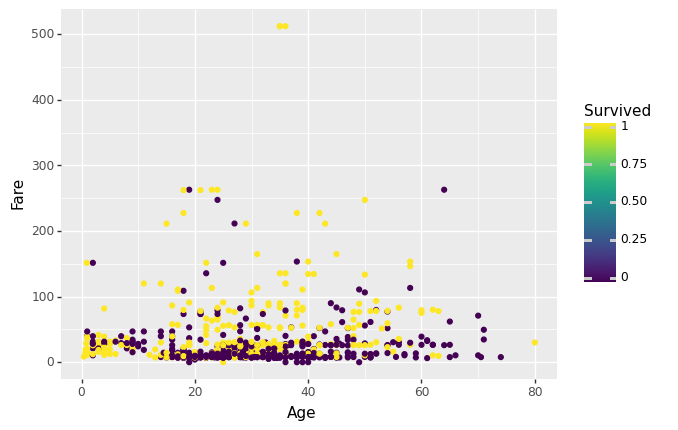

<ggplot: (-9223363258430891495)>


In [7]:
print(ggplot(titanic)
    + geom_point(aes("Age", "Fare", color="Survived"))
     )

/home/daniel-std/.local/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 177 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


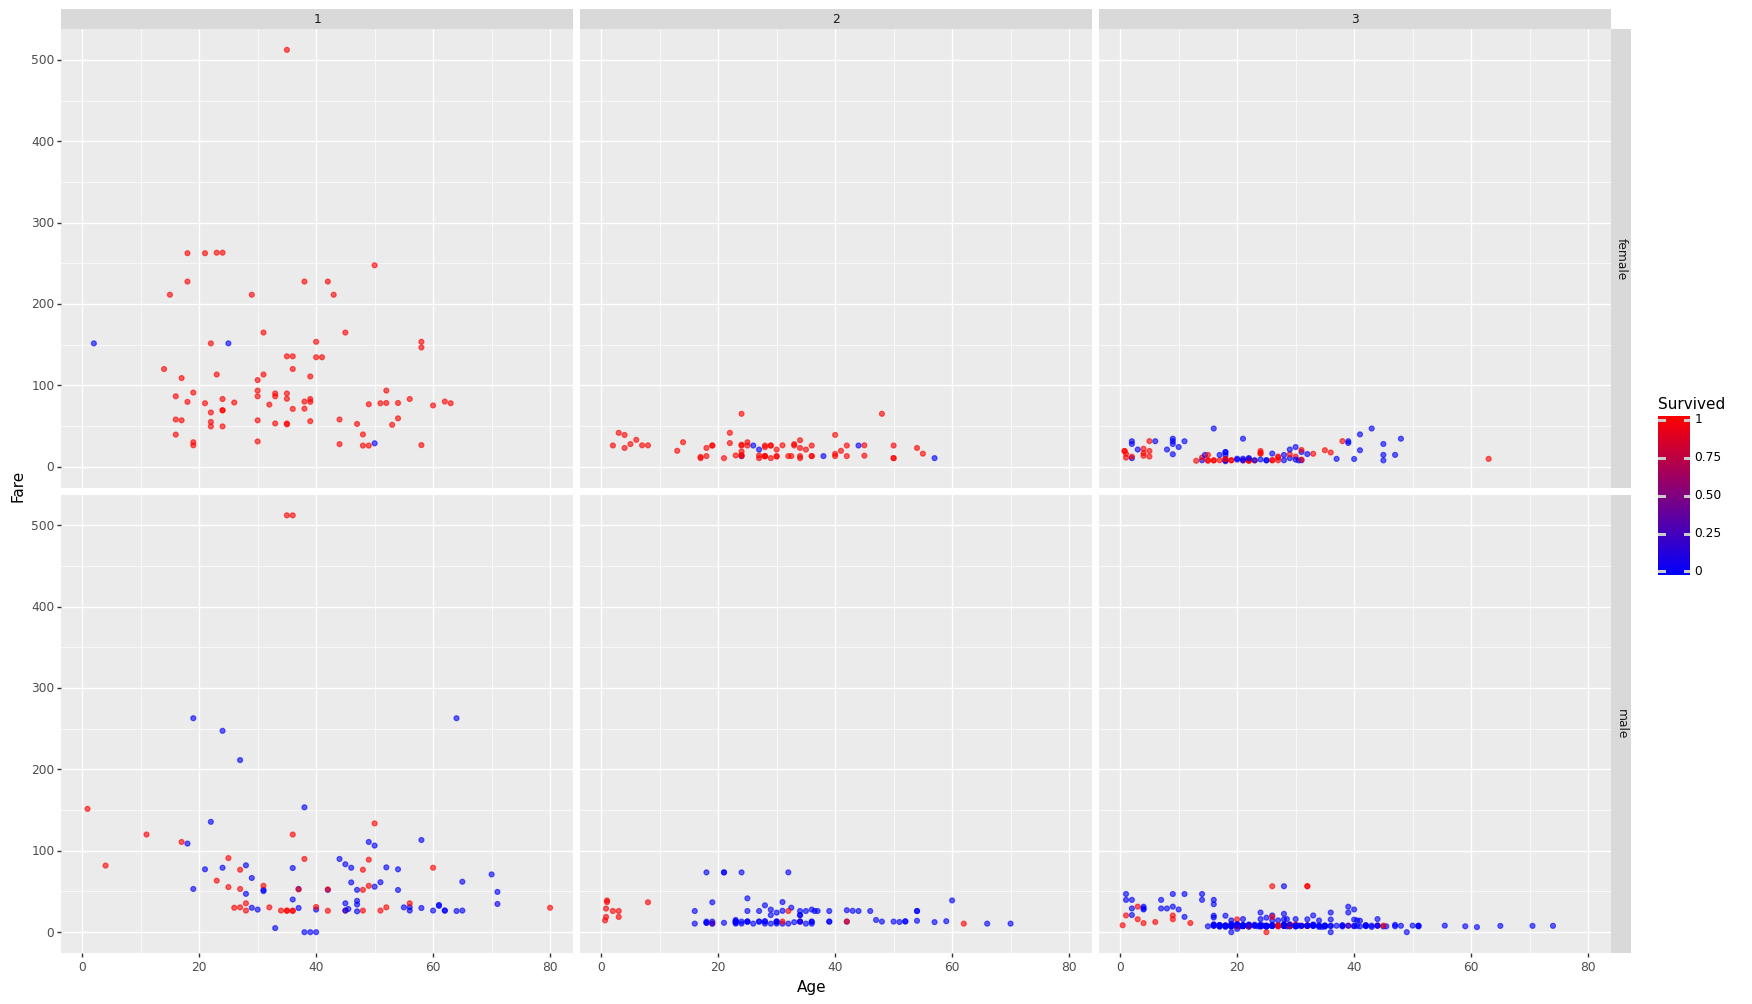

<ggplot: (8778423891695)>


In [8]:
print(ggplot(titanic) \
    + geom_point(aes('Age','Fare', color='Survived'), alpha=0.6)
    + facet_grid(('Sex','Pclass'))
    + scale_color_gradient(low="blue",high="red")
    + theme(figure_size=(20.0,12.0))
     )

* we observe, that out of the female passengers, a significanly higher ratio survived than of the male passengers
* we also see that of the first and second class, almost all females survived, while of the 3rd class, approximately more females died than survived)

Before we use a groupby operation to create a multiindex DF that counts each small group, let's bin the `Fare` parameter and take a simple look at the relation between Fare and survival.

In [9]:
# remove outliers:
titanic_300 = titanic.copy().query("Fare < 300")

/home/daniel-std/.local/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 56'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


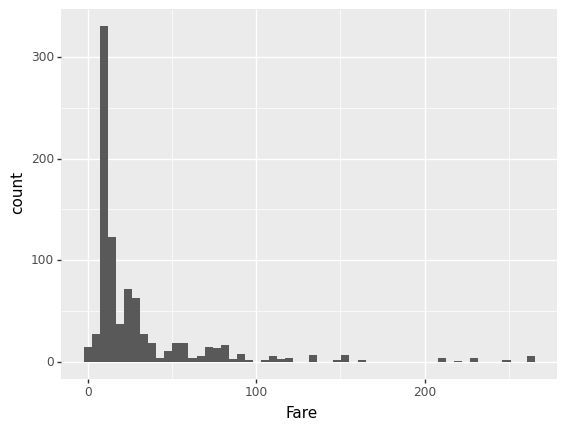

<ggplot: (-9223363258435229152)>


In [10]:
print(ggplot(titanic_300) \
    + geom_histogram(aes('Fare'))
     )

/home/daniel-std/.local/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 177 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


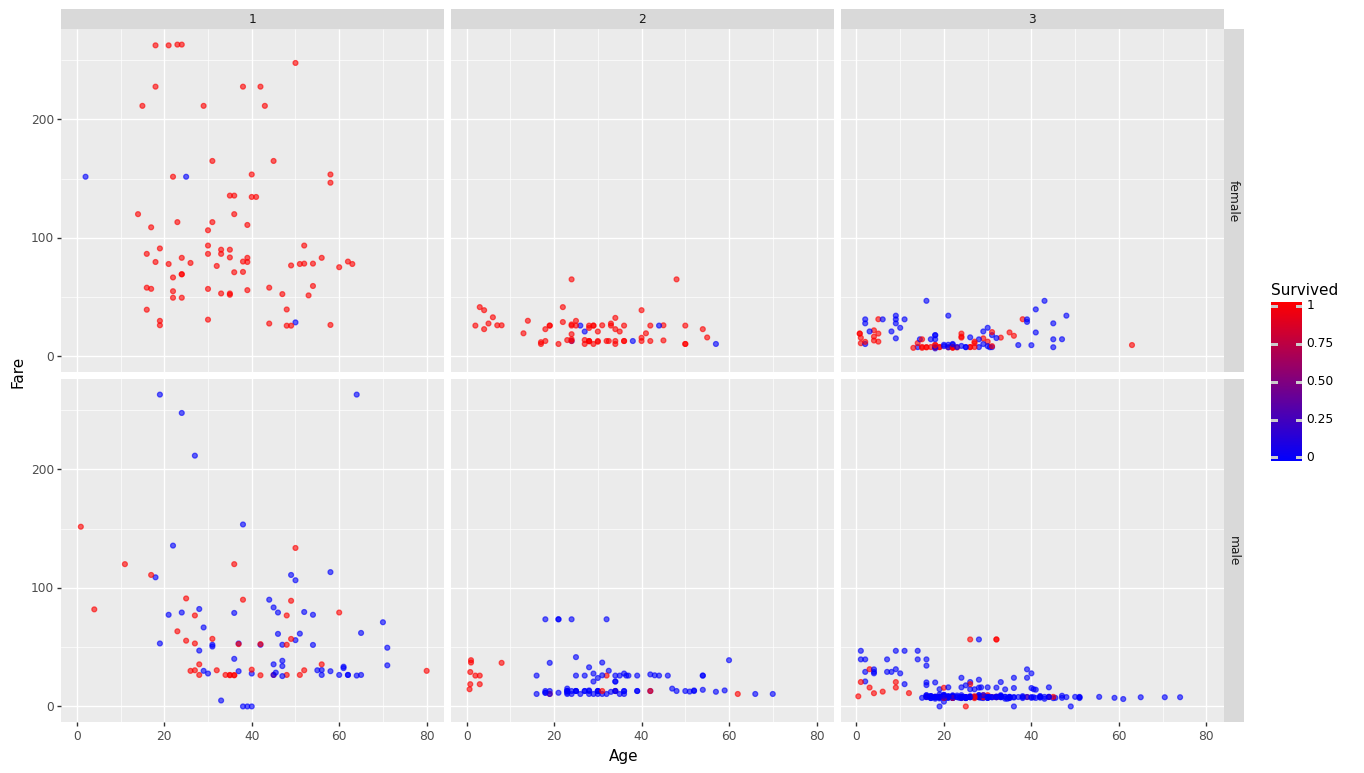

<ggplot: (8778423873081)>


In [11]:
print(ggplot(titanic_300) \
    + geom_point(aes('Age','Fare', color='Survived'), alpha=0.6)
    + facet_grid(('Sex','Pclass'))
    + scale_color_gradient(low="blue",high="red")
    + theme(figure_size=(15.0,9.0))
     )

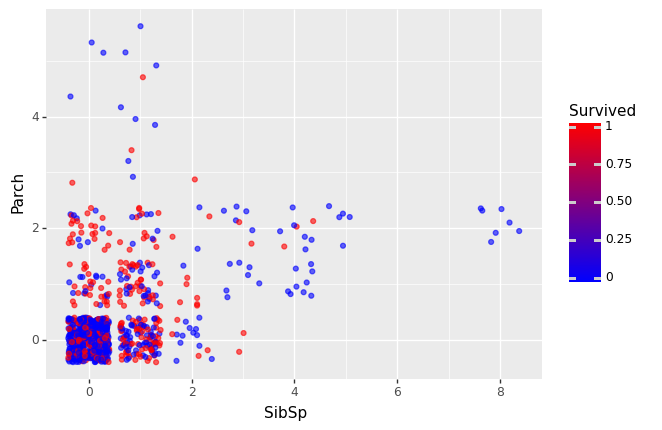

<ggplot: (8778418889185)>


In [12]:
print(ggplot(titanic_300)
    + geom_jitter(aes('SibSp', 'Parch', color='Survived'), alpha=0.6)
    + scale_color_gradient(low="blue", high="red")
    )

Seems like people with 1-2 Parents or siblings did best at surviving! But that may also be because of other circumstances just as wealth...
-> explore!!

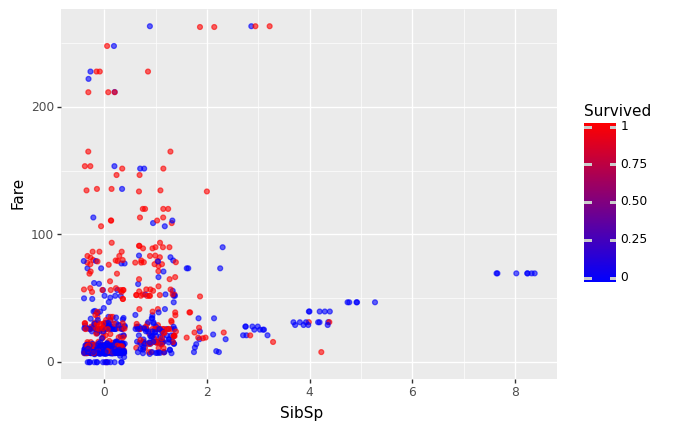

<ggplot: (8778419352356)>


In [13]:
print(ggplot(titanic_300)
    + geom_jitter(aes('SibSp', 'Fare', color='Survived'), alpha=0.6)
    + scale_color_gradient(low="blue", high="red")
    )

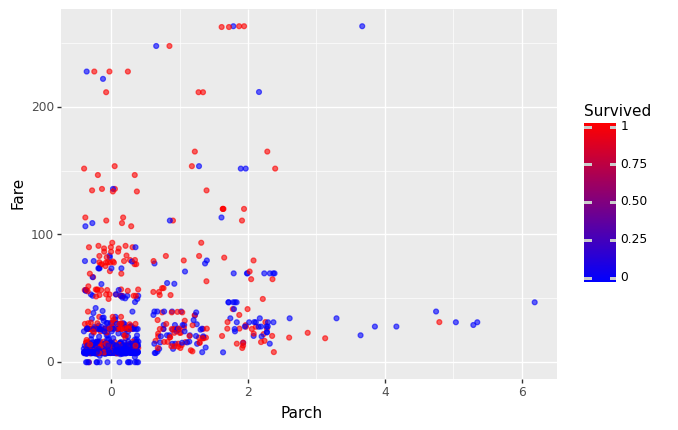

<ggplot: (-9223363258435423442)>


In [14]:
print(ggplot(titanic_300)
    + geom_jitter(aes('Parch', 'Fare', color='Survived'), alpha=0.6)
    + scale_color_gradient(low="blue", high="red")
    )

Now it looks like higher sibling / parent number predicts a lower probability of survival

In [15]:
# wrong apporach:
#titanic_grouped_1 = (titanic.copy()
#                    .drop(columns=["PassengerId", "Name", "SibSp", "Parch", "Ticket", "Cabin", "Embarked"])
#                    .groupby(["Sex", "Pclass", "Age", "Fare"])
#                    .agg("count")
#                    )
#display(titanic_grouped_1)

# define bins
bins_age = [0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84]
labels_age = ["1-7", "8-14", "15-21", "22-28", "29-35", "36-42", "43-49", "50-56", "57-63", "64-70", "71-77", "78-84"]
bins_fare = [0, 8, 12, 30, 870]
labels_fare = ["Third Class", "Second Class", "First Class (berth)", "First Class (parlor suite)"]

# classify rows by bin labels
titanic_cut_1 = titanic.copy()
titanic_cut_1["Age_bins"] = pd.cut(titanic_cut_1["Age"], bins=bins_age, labels=labels_age, right=True)
titanic_cut_1["Fare_bins"] = pd.cut(titanic_cut_1["Fare"], bins=bins_fare, labels=labels_fare, right=True)
titanic_grouped_2 = (titanic_cut_1.copy()
                    .drop(columns=["Age", "Fare", "PassengerId", "Name", "SibSp", "Parch", "Ticket", "Cabin", "Embarked", "Pclass"])
                    .groupby(["Sex", "Fare_bins", "Age_bins"])
                    .agg({"Survived":["sum", "count"]})
                    )
titanic_grouped_2.loc[:,("Survived","Survived_ratio")] = titanic_grouped_2.loc[:,("Survived","sum")] / titanic_grouped_2.loc[:,("Survived","count")]
#titanic_grouped_2["Survived_ratio"] = titanic_grouped_2.groupby(level=0).apply(lambda x: x/float(x.count()))
#display(titanic_grouped_2.loc[:,("Survived", "count")])
titanic_grouped_2 = titanic_grouped_2.droplevel(0, axis=1).reset_index()
display(titanic_grouped_2)
titanic.query("Survived == 1").count()


bins_age_2 = [0,20,40,60,80]
labels_age_2 = ["1-20", "21-40", "41-60", "61-80"]

titanic_cut_2 = titanic.copy()
titanic_cut_2["Age_bins"] = pd.cut(titanic_cut_2["Age"], bins=bins_age_2, labels=labels_age_2, right=True)
titanic_cut_2["Fare_bins"] = pd.cut(titanic_cut_2["Fare"], bins=bins_fare, labels=labels_fare, right=True)
titanic_grouped_3 = (titanic_cut_2.copy()
                    .drop(columns=["Age", "Fare", "PassengerId", "Name", "SibSp", "Parch", "Ticket", "Cabin", "Embarked", "Pclass"])
                    .groupby(["Sex", "Fare_bins", "Age_bins"])
                    .agg({"Survived":["sum", "count"]})
                    )
titanic_grouped_3.loc[:,("Survived","Survived_ratio")] = titanic_grouped_3.loc[:,("Survived","sum")] / titanic_grouped_3.loc[:,("Survived","count")]
#titanic_grouped_2["Survived_ratio"] = titanic_grouped_2.groupby(level=0).apply(lambda x: x/float(x.count()))
#display(titanic_grouped_2.loc[:,("Survived", "count")])
titanic_grouped_3 = titanic_grouped_3.droplevel(0, axis=1).reset_index()
display(titanic_grouped_3)


,Sex,Fare_bins,Age_bins,sum,count,Survived_ratio
0,female,Third Class,1-7,NaN,0,NaN
1,female,Third Class,8-14,1.0,2,0.500000
2,female,Third Class,15-21,8.0,11,0.727273
3,female,Third Class,22-28,8.0,12,0.666667
4,female,Third Class,29-35,0.0,2,0.000000
...,...,...,...,...,...,...
91,male,First Class (parlor suite),50-56,3.0,11,0.272727
92,male,First Class (parlor suite),57-63,1.0,5,0.200000
93,male,First Class (parlor suite),64-70,0.0,3,0.000000
94,male,First Class (parlor suite),71-77,0.0,2,0.000000


,Sex,Fare_bins,Age_bins,sum,count,Survived_ratio
0,female,Third Class,1-20,8.0,11,0.727273
1,female,Third Class,21-40,9.0,16,0.562500
2,female,Third Class,41-60,0.0,1,0.000000
3,female,Third Class,61-80,NaN,0,NaN
4,female,Second Class,1-20,7.0,10,0.700000
5,female,Second Class,21-40,6.0,14,0.428571
6,female,Second Class,41-60,2.0,3,0.666667
7,female,Second Class,61-80,1.0,1,1.000000
8,female,First Class (berth),1-20,22.0,33,0.666667
9,female,First Class (berth),21-40,43.0,54,0.796296


/home/daniel-std/.local/lib/python3.6/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 24 rows containing missing values.
  data = self.position.setup_data(self.data, params)


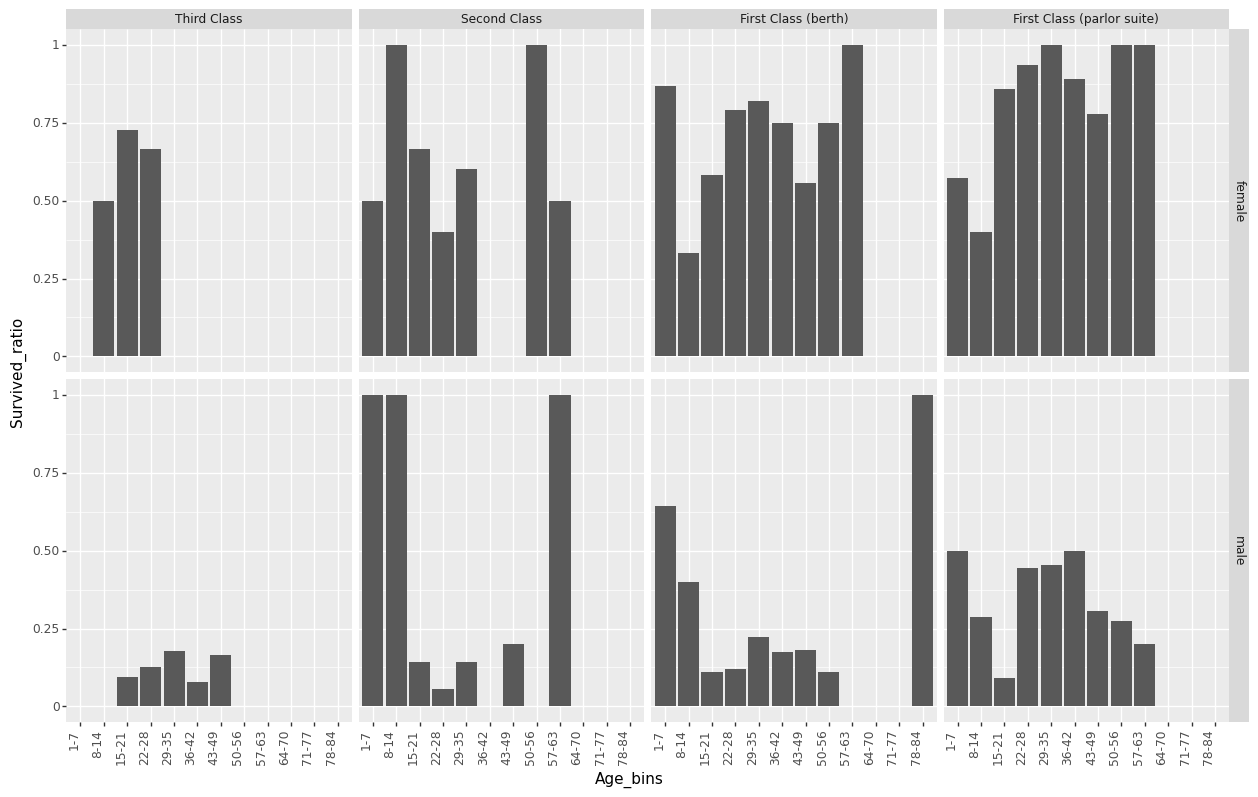

<ggplot: (8778419262030)>


/home/daniel-std/.local/lib/python3.6/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 2 rows containing missing values.
  data = self.position.setup_data(self.data, params)


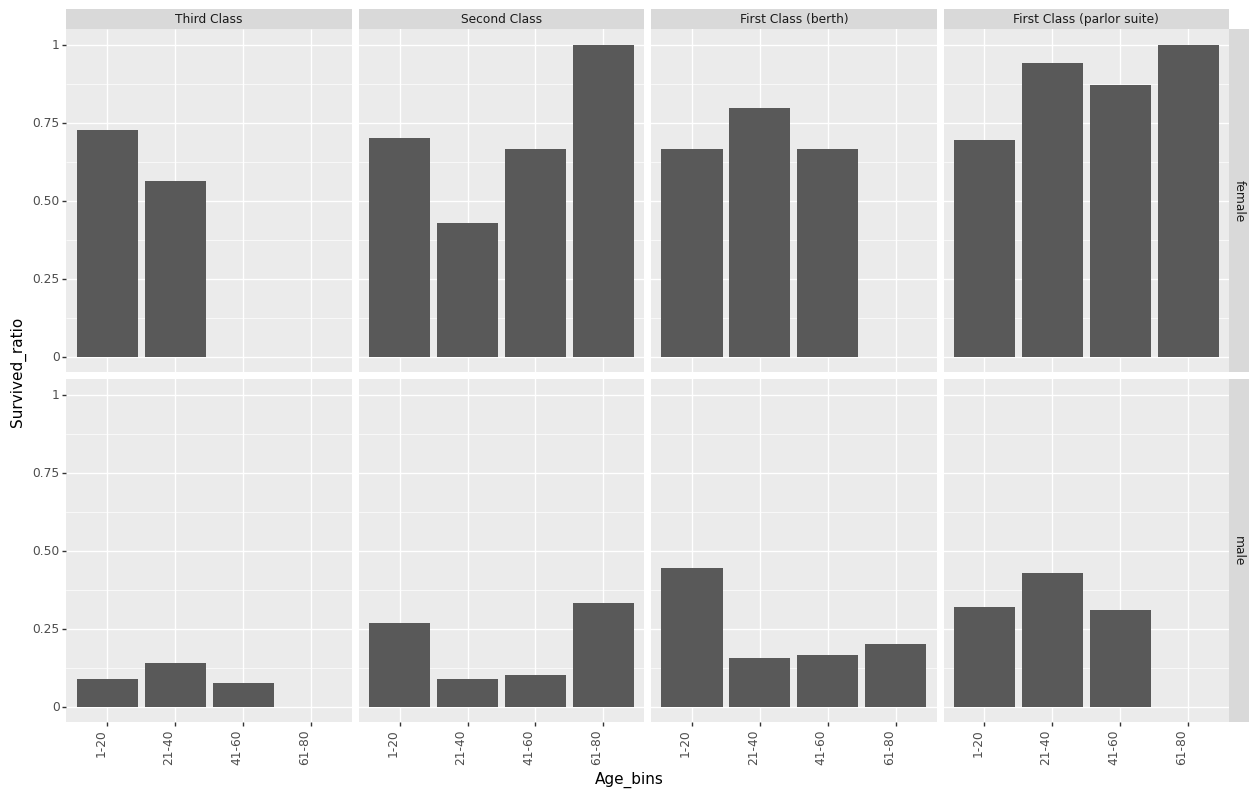

<ggplot: (-9223363258435457308)>


In [16]:
print(ggplot(titanic_grouped_2.reset_index())
    + geom_col(aes("Age_bins", "Survived_ratio"))
    + facet_grid(("Sex", "Fare_bins"))
    + theme(figure_size=(15.0,9.0))
    + theme(axis_text_x=element_text(rotation=90, hjust=1))
)

print(ggplot(titanic_grouped_3.reset_index())
    + geom_col(aes("Age_bins", "Survived_ratio"))
    + facet_grid(("Sex", "Fare_bins"))
    + theme(figure_size=(15.0,9.0))
    + theme(axis_text_x=element_text(rotation=90, hjust=1))
)

,SibSp,sum,count,Survived_ratio
0,0,210,608,0.345395
1,1,112,209,0.535885
2,2,13,28,0.464286
3,3,4,16,0.250000
4,4,3,18,0.166667
5,5,0,5,0.000000
6,8,0,7,0.000000


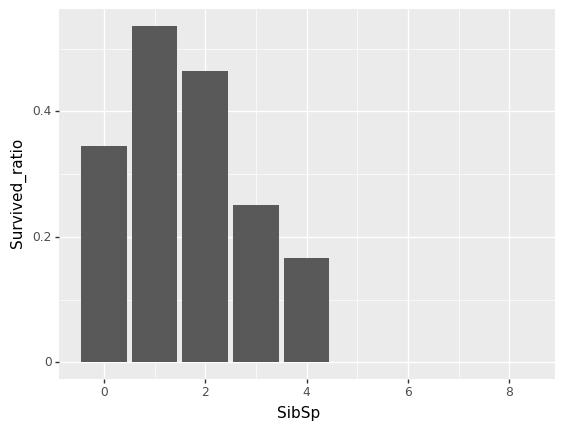

<ggplot: (8778419599112)>


,Parch,sum,count,Survived_ratio
0,0,233,678,0.345395
1,1,65,118,0.535885
2,2,40,80,0.464286
3,3,3,5,0.250000
4,4,0,4,0.166667
5,5,1,5,0.000000
6,6,0,1,0.000000


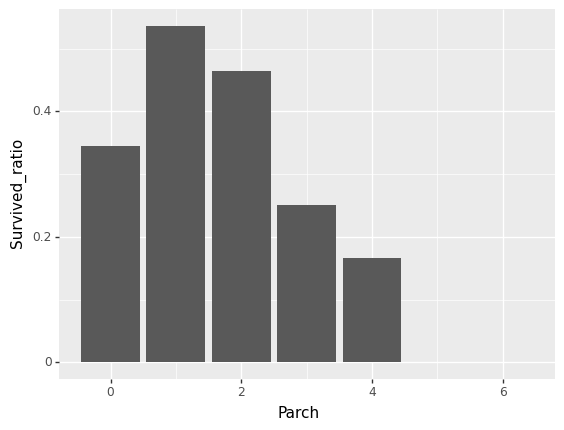

<ggplot: (-9223363258435163553)>


In [17]:
titanic_grouped_4 = (titanic_cut_1.copy()
                    .drop(columns=["Age", "Fare", "PassengerId", "Name", "Parch", "Ticket", "Cabin", "Embarked", "Pclass"])
                    .groupby("SibSp")
                    .agg({"Survived":["sum","count"]})
                    )

titanic_grouped_4 = titanic_grouped_4.droplevel(0, axis=1)
titanic_grouped_4["Survived_ratio"] = titanic_grouped_4["sum"] / titanic_grouped_4["count"]
titanic_grouped_4 = titanic_grouped_4.reset_index()
display(titanic_grouped_4)

print(ggplot(titanic_grouped_4)
    + geom_col(aes("SibSp", "Survived_ratio"))
     )

titanic_grouped_5 = (titanic_cut_1.copy()
                    .drop(columns=["Age", "Fare", "PassengerId", "Name", "SibSp", "Ticket", "Cabin", "Embarked", "Pclass"])
                    .groupby("Parch")
                    .agg({"Survived":["sum","count"]})
                    )

titanic_grouped_5 = titanic_grouped_5.droplevel(0, axis=1)
titanic_grouped_5["Survived_ratio"] = titanic_grouped_4["sum"] / titanic_grouped_4["count"]
titanic_grouped_5 = titanic_grouped_5.reset_index()
display(titanic_grouped_5)

print(ggplot(titanic_grouped_5)
    + geom_col(aes("Parch", "Survived_ratio"))
     )

/home/daniel-std/.local/lib/python3.6/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 9 rows containing missing values.
  data = self.position.setup_data(self.data, params)


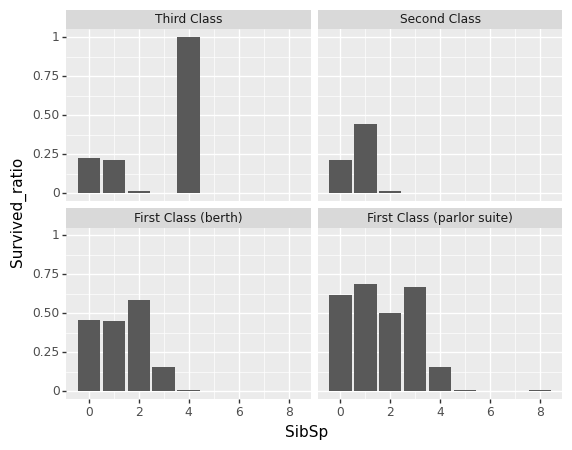

<ggplot: (8778419664062)>


/home/daniel-std/.local/lib/python3.6/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 9 rows containing missing values.
  data = self.position.setup_data(self.data, params)


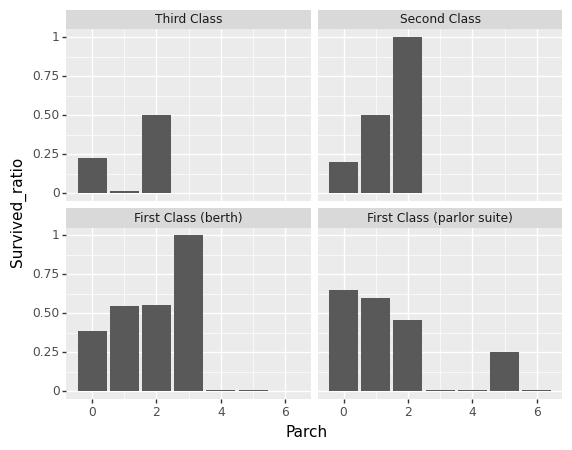

<ggplot: (8778423897334)>


In [18]:
bins_fare = [0, 8, 12, 30, 870]
labels_fare = ["Third Class", "Second Class", "First Class (berth)", "First Class (parlor suite)"]

# classify rows by bin labels
titanic_cut_3 = titanic.copy()
titanic_cut_3["Fare_bins"] = pd.cut(titanic_cut_3["Fare"], bins=bins_fare, labels=labels_fare, right=True)


titanic_grouped_6 = (titanic_cut_3.copy()
                    .drop(columns=["Age", "Fare", "PassengerId", "Name", "Parch", "Ticket", "Cabin", "Embarked", "Pclass"])
                    .groupby(["Fare_bins","SibSp"])
                    .agg({"Survived":["sum","count"]})
                    )


titanic_grouped_6 = titanic_grouped_6.droplevel(0, axis=1)
titanic_grouped_6["Survived_ratio"] = titanic_grouped_6["sum"] / titanic_grouped_6["count"]
titanic_grouped_6 = titanic_grouped_6.reset_index()

# add a small scalar to the 0 survival rate cases in order to make them more visible in the plot
titanic_grouped_6["Survived_ratio"] = titanic_grouped_6["Survived_ratio"].apply(lambda x: x+0.01 if x == 0.0 else x)
#display(titanic_grouped_6)

print(ggplot(titanic_grouped_6)
    + geom_col(aes("SibSp", "Survived_ratio"))
    + facet_wrap("Fare_bins")
     )


titanic_grouped_7 = (titanic_cut_3.copy()
                    .drop(columns=["Age", "Fare", "PassengerId", "Name", "SibSp", "Ticket", "Cabin", "Embarked", "Pclass"])
                    .groupby(["Fare_bins","Parch"])
                    .agg({"Survived":["sum","count"]})
                    )


titanic_grouped_7 = titanic_grouped_7.droplevel(0, axis=1)
titanic_grouped_7["Survived_ratio"] = titanic_grouped_7["sum"] / titanic_grouped_7["count"]
titanic_grouped_7 = titanic_grouped_7.reset_index()

# add a small scalar to the 0 survival rate cases in order to make them more visible in the plot
titanic_grouped_7["Survived_ratio"] = titanic_grouped_7["Survived_ratio"].apply(lambda x: x+0.01 if x == 0.0 else x)
#display(titanic_grouped_7)

print(ggplot(titanic_grouped_7)
    + geom_col(aes("Parch", "Survived_ratio"))
    + facet_wrap("Fare_bins")
     )


<br>

## Model Building

Binary Prediction models: http://mfviz.com/binary-predictions/

### Support Vector Machines - scikit-learn

Let's ignore the following features:
* Name
* Ticket
* Cabin
* Embarked

#### Transforming categoricals

We need to use **OneHotEncoding** for all categoricals, where there is no "natural" order. So in our case this is only important for `Sex` .  

The SibSp, Parch, Age_bins and Fare_bins are all **ordinal** values and as such we want to use an **OrdinalEncoder** for them.

In [19]:
print(titanic_test.info())
print(titanic.info())
pd.set_option('display.max_rows', None)
#display(titanic_test.query("Age != Age").head(100))
pd.set_option('display.max_rows', 60)
#pd.options.display.max_rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pcl

**How do I make a prediction for observations where one of my features is missing?**  
-> predict missing values?

#### Predicting missing values (instead of using the mode or mean)

Another way: combining the valid observations of the test and train set to predict missing values!  

-> this means that for the prediction we mix both in order to obtain a higher accuracy!  

-> **OR** we only use training data of the test dataset!


Probably best solution: create a new category for unknown Age (because just by thinking about it we can be pretty sure that a missing age means that the person died).
That way we train the algorithm to detect missing ages as not surviving!

**Note, that the following code is found to be unsufficient to predict ages! Instead, the smartest way seems to be to introduce a category "unknown" that represents missing age values**

In [20]:
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# check which columns have missing values in our TRAINING SET
display(titanic_cut_1.info())
# -> Age, Cabin, Age_bins, Fare_bins
# As we ignore Age and Cabins, we only focus on Age_bins and Fare_bins

# BUT we still need to check which columns have missing values in our TEST SET
display(titanic_test.info())
# -> Age, Cabin, Fare (just 1 Row)
# check the 1 Fare row:
display(titanic_test.query("Fare != Fare"))

# check why Fare_bins could be NaN, see that it is due to a Fare of 0.0 which is excluded in our bins due to "right=True" parameter
#display(titanic_cut_1.loc[titanic_cut_1["Fare_bins"].isna()])

titanic_cut_1_nan = titanic_cut_1.copy().set_index("PassengerId")
# helper column
titanic_cut_1_nan["Fare_bins_nan"] = pd.isnull(titanic_cut_1_nan["Fare_bins"])
# fill Fare_bins based on helper column
titanic_cut_1_nan.loc[titanic_cut_1_nan["Fare_bins"].isnull(), "Fare_bins"] = "Third Class"
# drop helper column + other columns unrelated to the prediction
titanic_cut_1_nan = titanic_cut_1_nan.drop(columns=["Fare_bins_nan", "Age", "Name", "Ticket", "Cabin", "Fare", "Embarked", "Pclass", "Survived"])

#display(titanic_cut_1_nan.info()) # success!


# for Age_bins, we will build a quick SVM model
# first we need to transform distinct values

titanic_cut_1_nan = pd.get_dummies(titanic_cut_1_nan, columns=["Sex"], prefix_sep='_', drop_first=True)

# seperate into train & test set
titanic_cut_1_nan_train = titanic_cut_1_nan.copy().loc[~titanic_cut_1_nan["Age_bins"].isnull()]
titanic_cut_1_nan_test = titanic_cut_1_nan.copy().loc[titanic_cut_1_nan["Age_bins"].isnull()]

enc_ord = OrdinalEncoder()
titanic_cut_1_nan_train.loc[:,["SibSp", "Parch", "Age_bins", "Fare_bins"]] = enc_ord.fit_transform(titanic_cut_1_nan_train.loc[:,["SibSp", "Parch", "Age_bins", "Fare_bins"]])
# for test set we can not encode Age_bins as they are missing!
titanic_cut_1_nan_test.loc[:,["SibSp", "Parch", "Fare_bins"]] = enc_ord.fit_transform(titanic_cut_1_nan_test.loc[:,["SibSp", "Parch", "Fare_bins"]])



x_train = titanic_cut_1_nan_train.copy().drop(columns=["Age_bins"])
y_train = titanic_cut_1_nan_train.copy().loc[:,"Age_bins"]

# Create a svm Classifier
clf = svm.SVC(kernel="linear")

# Train the model using the training sets
clf.fit(x_train, y_train)

# drop Age_bins column to predict it
x_test = titanic_cut_1_nan_test.copy().drop(columns=["Age_bins"])

# predict the Age for the missing values in our train dataset:
y_pred = clf.predict(x_test)

# save predictions in a new dataframe along with the input parameters
titanic_cut_1_nan_pred_svm = x_test.copy()
titanic_cut_1_nan_pred_svm["Age_bins"] = y_pred


# now predict the Age_bins in the real test dataset!

# TRANSFORM THE TEST DATA
titanic_test_cut_1 = titanic_test.copy()
titanic_test_cut_1["Age_bins"] = pd.cut(titanic_test_cut_1["Age"], bins=bins_age, labels=labels_age, right=True)
titanic_test_cut_1["Fare_bins"] = pd.cut(titanic_test_cut_1["Fare"], bins=bins_fare, labels=labels_fare, right=True)

titanic_test_cut_1_nan = titanic_test_cut_1.copy().set_index("PassengerId")

# FILL fare bins with the value of the mode!
# helper column
titanic_test_cut_1_nan["Fare_bins_nan"] = pd.isnull(titanic_test_cut_1_nan["Fare_bins"])
# fill Fare_bins based on helper column
fare_bins_mode = stats.mode(titanic_test_cut_1_nan["Fare_bins"])[0][0]

display(fare_bins_mode)
titanic_test_cut_1_nan.loc[titanic_test_cut_1_nan["Fare_bins"].isnull(), "Fare_bins"] = fare_bins_mode
# drop helper column + other columns unrelated to the prediction
titanic_test_cut_1_nan = titanic_test_cut_1_nan.drop(columns=["Fare_bins_nan", "Age", "Name", "Ticket", "Cabin", "Fare", "Embarked", "Pclass"])

titanic_test_cut_1_nan = pd.get_dummies(titanic_test_cut_1_nan, columns=["Sex"], prefix_sep='_', drop_first=True)

# seperate into train & test set
titanic_test_cut_1_nan_train = titanic_test_cut_1_nan.copy().loc[~titanic_test_cut_1_nan["Age_bins"].isnull()]
titanic_test_cut_1_nan_test = titanic_test_cut_1_nan.copy().loc[titanic_test_cut_1_nan["Age_bins"].isnull()]

# ordinal encoding
enc_ord = OrdinalEncoder()
titanic_test_cut_1_nan_train.loc[:,["SibSp", "Parch", "Age_bins", "Fare_bins"]] = enc_ord.fit_transform(titanic_test_cut_1_nan_train.loc[:,["SibSp", "Parch", "Age_bins", "Fare_bins"]])
# for test set we can not encode Age_bins as they are missing!
titanic_test_cut_1_nan_test.loc[:,["SibSp", "Parch", "Fare_bins"]] = enc_ord.fit_transform(titanic_test_cut_1_nan_test.loc[:,["SibSp", "Parch", "Fare_bins"]])

# check accuracy with known ages in the test set:
x_test_acc = titanic_test_cut_1_nan_train.copy().drop(columns=["Age_bins"])
y_test_acc_pred = clf.predict(x_test_acc)

x_test_acc_result = titanic_test_cut_1_nan_train.copy()
x_test_acc_result["Age_bins_pred"] = y_test_acc_pred
display(x_test_acc_result)
display("Accuracy:", (len(x_test_acc_result.query("Age_bins == Age_bins_pred"))/len(x_test_acc_result)))
# linear SVM kernel: 0,322 acc
# rbf SVM kernel: 0,268 acc
# poly SVM kernel: 0,232 acc
# poly SVM kernel: 0,190 acc
# test against mode "prediction"
x_test_acc_mode = titanic_test_cut_1_nan.copy().loc[~titanic_test_cut_1_nan["Age_bins"].isnull()]
#x_test_acc_mode["Age_bins_pred"] = stats.mode(titanic_cut_1_nan.loc[~titanic_cut_1_nan["Age_bins"].isnull(), "Age_bins"])[0][0]
# manual setting with mean of Age of the titanic set: 29.699
#x_test_acc_mode["Age_bins_pred"] = "29-35" -> Accuracy of 0,160
display("Accuracy:", (len(x_test_acc_mode.query("Age_bins == Age_bins_pred"))/len(x_test_acc_mode)))



x_test = titanic_test_cut_1_nan_test.copy().drop(columns=["Age_bins"])

y_pred = clf.predict(x_test)

# save predictions in a new dataframe along with the input parameters
titanic_test_cut_1_nan_pred_svm = x_test.copy()
titanic_test_cut_1_nan_pred_svm["Age_bins"] = y_pred

# next steps: improve accuracy of age_bins, use new non-NaN test dataset to make the first prediction!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    object  
 12  Age_bins     714 non-null    category
 13  Fare_bins    876 non-null    category
dtypes: category(2), float64(2), int64(5), object(5)
memory usage: 86.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


'First Class (berth)'

,SibSp,Parch,Age_bins,Fare_bins,Sex_male,Age_bins_pred
PassengerId,,,,,,
892,0.0,0.0,3.0,3.0,1,2.0
893,1.0,0.0,5.0,3.0,0,2.0
894,0.0,0.0,7.0,2.0,1,2.0
895,0.0,0.0,2.0,2.0,1,2.0
896,1.0,1.0,2.0,0.0,0,0.0
...,...,...,...,...,...,...
1301,1.0,1.0,0.0,0.0,0,0.0
1303,1.0,0.0,4.0,1.0,0,3.0
1304,0.0,0.0,2.0,3.0,0,2.0


'Accuracy:'

0.32228915662650603

UndefinedVariableError: name 'Age_bins_pred' is not defined

#### Filling Age_bins NaN values with "unknown"

In [ ]:
titanic.dropna(subset=["Age"])["Age"].mean()

#### Manual data preparation

In [ ]:
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

titanic_prep = titanic_cut_1.copy().drop(columns=["Name", "Ticket", "Cabin", "Embarked", "Age", "Fare", "Pclass"]).set_index("PassengerId")

# OneHotEncoder to transform categoricals
#drop_binary_enc = OneHotEncoder(drop='first').fit_transform(titanic_prep.loc[:,["Sex","SibSp","Parch"]]).toarray()
#display(drop_binary_enc)
#drop_binary_enc.transform(titanic_prep.loc[:,["Pclass","Sex","SibSp","Parch"]]).toarray()

titanic_prep_enc = pd.get_dummies(titanic_prep, columns=["Sex"], prefix_sep='_', drop_first=True)

# fill NaN Age_bins
# get existing categories
age_bins_cats = pd.Categorical(titanic_prep_enc["Age_bins"].cat.categories.to_series().sort_values(), ordered=True, dtype="category")
# reorder categories according to reality
age_bins_cats = age_bins_cats.reorder_categories(["1-7", "8-14", "15-21", "22-28", "29-35", "36-42", "43-49", "50-56", "57-63", "64-70", "71-77", "78-84"], ordered=True)
# add new category to replace NaNs
age_bins_cats = age_bins_cats.add_categories("unknown")
# set new Categorical variable to include "unknown"
titanic_prep_enc["Age_bins"] = titanic_prep_enc["Age_bins"].astype(age_bins_cats)
# fill NaNs with "unknown"
titanic_prep_enc["Age_bins"] = titanic_prep_enc["Age_bins"].fillna("unknown")
#display(titanic_prep_enc.info())


# fill NaN Fare_bins
titanic_prep_enc["Fare_bins_nan"] = pd.isnull(titanic_prep_enc["Fare_bins"])
# fill Fare_bins based on helper column
titanic_prep_enc.loc[titanic_prep_enc["Fare_bins"].isnull(), "Fare_bins"] = "Third Class"
# drop helper column + other columns unrelated to the prediction
titanic_prep_enc = titanic_prep_enc.drop(columns=["Fare_bins_nan"])
#display(titanic_prep_enc.info())


# ordinal encoding of the training set
enc_ord = OrdinalEncoder()
titanic_prep_enc.loc[:,["SibSp", "Parch", "Age_bins", "Fare_bins"]] = enc_ord.fit_transform(titanic_prep_enc.loc[:,["SibSp", "Parch", "Age_bins", "Fare_bins"]])


x_train = titanic_prep_enc.copy().drop(columns=["Survived"])
y_train = titanic_prep_enc.copy().loc[:,"Survived"]

# Create a svm Classifier
#clf = svm.SVC(kernel="linear") # linear Kernel
clf = svm.SVC()

# Train the model using the training sets
clf.fit(x_train, y_train)

# TRANSFORM THE TEST DATA
titanic_test_cut_1 = titanic_test.copy()
titanic_test_cut_1["Age_bins"] = pd.cut(titanic_test_cut_1["Age"], bins=bins_age, labels=labels_age, right=True)
titanic_test_cut_1["Fare_bins"] = pd.cut(titanic_test_cut_1["Fare"], bins=bins_fare, labels=labels_fare, right=True)
titanic_test_prep = titanic_test_cut_1.copy().drop(columns=["Name", "Ticket", "Cabin", "Embarked", "Age", "Fare", "Pclass"]).set_index("PassengerId")

titanic_test_prep_enc = pd.get_dummies(titanic_test_prep, columns=["Sex"], prefix_sep='_', drop_first=True)

# fill NaN Age_bins
# set new Categorical variable to include "unknown"
titanic_test_prep_enc["Age_bins"] = titanic_test_prep_enc["Age_bins"].astype(age_bins_cats)
# fill NaNs with "unknown"
titanic_test_prep_enc["Age_bins"] = titanic_test_prep_enc["Age_bins"].fillna("unknown")


# fill NaN Fare_bins
titanic_test_prep_enc["Fare_bins_nan"] = pd.isnull(titanic_test_prep_enc["Fare_bins"])
# fill Fare_bins based on helper column
titanic_test_prep_enc.loc[titanic_test_prep_enc["Fare_bins"].isnull(), "Fare_bins"] = "Third Class"
# drop helper column + other columns unrelated to the prediction
titanic_test_prep_enc = titanic_test_prep_enc.drop(columns=["Fare_bins_nan"])


# ordinal encoding of the training set
enc_ord = OrdinalEncoder()
titanic_test_prep_enc.loc[:,["SibSp", "Parch", "Age_bins", "Fare_bins"]] = enc_ord.fit_transform(titanic_test_prep_enc.loc[:,["SibSp", "Parch", "Age_bins", "Fare_bins"]])
#display(titanic_test_prep_enc)



x_test = titanic_test_prep_enc.copy()

# predict the response for the test dataset
y_pred = clf.predict(x_test)

titanic_pred_svm = titanic_test.copy()
titanic_pred_svm["Survived"] = y_pred

titanic_pred_svm_submission = titanic_pred_svm.copy().loc[:,["PassengerId", "Survived"]].set_index("PassengerId")
display(titanic_pred_svm_submission)
titanic_pred_svm_submission.to_csv("Submission/titanic_submission_svm_rbv.csv")

#### How to Improve
* try different bin sizes for the Age (today: 12, could maybe make more sense to reduce to 4)
* try different bin sizes for the Fare
* try a different algorithm
* try ensemble algorithms

#### Improvement: Reduce Age bin numbers

Build transformation pipeline:

In [21]:
def transform_titanic(dataframe, bins_age, labels_age, bins_fare, labels_fare, columns_to_drop):
    df = dataframe.copy()
    # bin Age
    df["Age_bins"] = pd.cut(df["Age"], bins=bins_age, labels=labels_age, right=True)
    # bin Fare
    df["Fare_bins"] = pd.cut(df["Fare"], bins=bins_fare, labels=labels_fare, right=True)
    # drop columns & set index
    df_prep = df.copy().drop(columns = columns_to_drop).set_index("PassengerId")
    return df_prep

def encode_titanic(dataframe, dummy_columns, ordinal_encoding_columns, labels_age):
    # dummies
    df_prep_enc = pd.get_dummies(dataframe, columns=dummy_columns, prefix_sep='_', drop_first=True)
    
    # fill NaN Age_bins
    # get existing categories
    age_bins_cats = pd.Categorical(df_prep_enc["Age_bins"].cat.categories.to_series().sort_values(), ordered=True, dtype="category")
    # reorder categories according to reality
    age_bins_cats = age_bins_cats.reorder_categories(labels_age, ordered=True)
    # add new category to replace NaNs
    age_bins_cats = age_bins_cats.add_categories("unknown")
    # set new Categorical variable to include "unknown"
    df_prep_enc["Age_bins"] = df_prep_enc["Age_bins"].astype(age_bins_cats)
    # fill NaNs with "unknown"
    df_prep_enc["Age_bins"] = df_prep_enc["Age_bins"].fillna("unknown")


    # fill NaN Fare_bins
    df_prep_enc["Fare_bins_nan"] = pd.isnull(df_prep_enc["Fare_bins"])
    # fill Fare_bins based on helper column
    df_prep_enc.loc[df_prep_enc["Fare_bins"].isnull(), "Fare_bins"] = stats.mode(df_prep_enc["Fare_bins"])[0][0]
    # drop helper column + other columns unrelated to the prediction
    df_prep_enc = df_prep_enc.drop(columns=["Fare_bins_nan"])
    
    # ordinal encoding
    enc_ord = OrdinalEncoder()
    df_prep_enc.loc[:,ordinal_encoding_columns] = enc_ord.fit_transform(df_prep_enc.loc[:,ordinal_encoding_columns])
    return df_prep_enc

def predict_survival(dataframe_prep_enc, dataframe_test_prep_enc, model, dataframe_test, submission_file_name):
    x_train = dataframe_prep_enc.copy().drop(columns=["Survived"])
    y_train = dataframe_prep_enc.loc[:,"Survived"]
    
    # Train the model using the training sets
    model.fit(x_train, y_train)

    # observations to make predictions on of the TEST dataset
    x_test = dataframe_test_prep_enc.copy()

    # predict the response for the test dataset
    y_pred = model.predict(x_test)

    dataframe_pred = dataframe_test.copy()
    dataframe_pred["Survived"] = y_pred

    # prepare submission DF
    dataframe_pred_submission = dataframe_pred.copy().loc[:,["PassengerId", "Survived"]].set_index("PassengerId")
    display("Submission DF: ", "\n", dataframe_pred_submission)
    # save submission DF to csv_file
    submission_file_string = "Submission/" + submission_file_name + ".csv"
    dataframe_pred_submission.to_csv(submission_file_string)

In [22]:
from sklearn.tree import DecisionTreeClassifier

bins_age = [0, 20, 40, 60, 80]
labels_age = ["1-20", "21-40", "41-60", "61-80"]
bins_fare = [0, 8, 12, 30, 870]
labels_fare = ["Third Class", "Second Class", "First Class (berth)", "First Class (parlor suite)"]
columns_to_drop = ["Name", "Ticket", "Cabin", "Embarked", "Age", "Fare", "Pclass"]

dummy_columns = ["Sex"]
ordinal_encoding_columns = ["SibSp", "Parch", "Age_bins", "Fare_bins"]

# training set
titanic_df_prep = transform_titanic(titanic, bins_age, labels_age, bins_fare, labels_fare, columns_to_drop)
titanic_df_prep_enc = encode_titanic(titanic_df_prep, dummy_columns, ordinal_encoding_columns, labels_age)
display(titanic_df_prep_enc.info())

# test set]
titanic_test_df_prep = transform_titanic(titanic_test, bins_age, labels_age, bins_fare, labels_fare, columns_to_drop)
titanic_test_df_prep_enc = encode_titanic(titanic_test_df_prep, dummy_columns, ordinal_encoding_columns, labels_age)
#display(titanic_test_df_prep_enc.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   SibSp      891 non-null    float64
 2   Parch      891 non-null    float64
 3   Age_bins   891 non-null    float64
 4   Fare_bins  891 non-null    float64
 5   Sex_male   891 non-null    uint8  
dtypes: float64(4), int64(1), uint8(1)
memory usage: 42.6 KB


None

Fare_bins Survived     
                                 count  sum
0                 Third Class      226   51
1                Second Class      133   30
2         First Class (berth)      283  124
3  First Class (parlor suite)      234  136

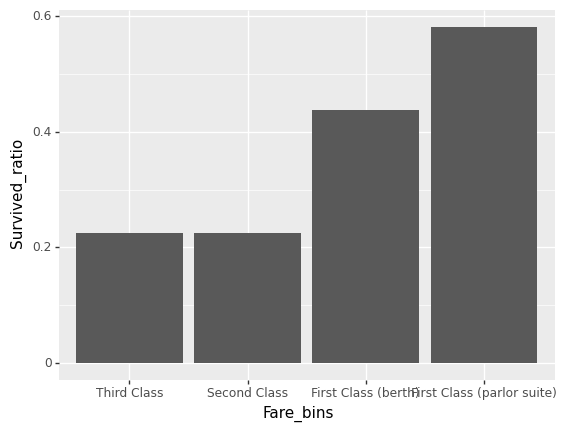

<ggplot: (8778419638122)>


In [23]:
titanic_df_prep_plot_farebins = titanic_df_prep.copy().groupby("Fare_bins").agg({"Survived":["count", "sum"]}).reset_index()
display(titanic_df_prep_plot_farebins)
# OBSERVE THE WAY WE ACCESS MULTIINDEX COLUMNS BY USING A TUPLE
titanic_df_prep_plot_farebins["Survived_ratio"] = titanic_df_prep_plot_farebins.loc[:, ("Survived", "sum")] / titanic_df_prep_plot_farebins.loc[:, ("Survived", "count")]
print(ggplot(titanic_df_prep_plot_farebins)
    + geom_col(aes("Fare_bins", "Survived_ratio"))
)

In [24]:
# Create a svm Classifier
clf = svm.SVC(kernel="linear") # linear Kernel
#clf = svm.SVC()

x_train = titanic_df_prep_enc.copy().drop(columns=["Survived"])
y_train = titanic_df_prep_enc.loc[:,"Survived"]
# Train the model using the training sets
clf.fit(x_train, y_train)

# observations to make predictions on of the TEST dataset
x_test = titanic_test_df_prep_enc.copy()

# predict the response for the test dataset
y_pred = clf.predict(x_test)

titanic_pred_svm = titanic_test.copy()
titanic_pred_svm["Survived"] = y_pred

# prepare submission DF
titanic_pred_svm_submission = titanic_pred_svm.copy().loc[:,["PassengerId", "Survived"]].set_index("PassengerId")
display(titanic_pred_svm_submission)
# save submission DF to csv_file
titanic_pred_svm_submission.to_csv("Submission/titanic_submission_svm_linear_4_age_bins.csv")

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


Decision Tree prediction

In [25]:
from sklearn.tree import DecisionTreeClassifier
# use predict_survival function
predict_survival(titanic_df_prep_enc, titanic_test_df_prep_enc, DecisionTreeClassifier(), titanic_test, "titanic_submission_dectree_4_age_bins")

'Submission DF: '

'\n'

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


Random Forest prediction

In [26]:
from sklearn.ensemble import RandomForestClassifier
predict_survival(titanic_df_prep_enc, titanic_test_df_prep_enc, RandomForestClassifier(), titanic_test, "titanic_submission_randfor_4_age_bins")

'Submission DF: '

'\n'

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


Random Forest prediction with only 20 Trees

In [27]:
from sklearn.ensemble import RandomForestClassifier
predict_survival(titanic_df_prep_enc, titanic_test_df_prep_enc, RandomForestClassifier(n_estimators=20), titanic_test, "titanic_submission_randfor_20trees_4_age_bins")

'Submission DF: '

'\n'

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB
predict_survival(titanic_df_prep_enc, titanic_test_df_prep_enc, GaussianNB(), titanic_test, "titanic_submission_gaussnb_4_age_bins")

'Submission DF: '

'\n'

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


New Transformed Data:

In [29]:

bins_age = [0, 20, 40, 60, 80]
labels_age = ["1-20", "21-40", "41-60", "61-80"]
bins_fare = [0, 8, 12, 30, 870]
labels_fare = ["Third Class", "Second Class", "First Class (berth)", "First Class (parlor suite)"]
columns_to_drop = ["Name", "Ticket", "Cabin", "Embarked", "Age", "Fare", "Pclass", "SibSp", "Parch"]

dummy_columns = ["Sex"]
ordinal_encoding_columns = ["Age_bins", "Fare_bins"]

# training set
titanic_df_prep = transform_titanic(titanic, bins_age, labels_age, bins_fare, labels_fare, columns_to_drop)
titanic_df_prep_enc = encode_titanic(titanic_df_prep, dummy_columns, ordinal_encoding_columns, labels_age)
display(titanic_df_prep_enc.info())

# test set]
titanic_test_df_prep = transform_titanic(titanic_test, bins_age, labels_age, bins_fare, labels_fare, columns_to_drop)
titanic_test_df_prep_enc = encode_titanic(titanic_test_df_prep, dummy_columns, ordinal_encoding_columns, labels_age)
#display(titanic_test_df_prep_enc.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Age_bins   891 non-null    float64
 2   Fare_bins  891 non-null    float64
 3   Sex_male   891 non-null    uint8  
dtypes: float64(2), int64(1), uint8(1)
memory usage: 28.7 KB


None

RBF Support Vector Machines without "SibSp" and "Parch"

In [30]:
from sklearn.svm import SVC
predict_survival(titanic_df_prep_enc, titanic_test_df_prep_enc, SVC(), titanic_test, "titanic_submission_svm_rbf_4_age_bins_no_sibsp_parch")

'Submission DF: '

'\n'

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


**Linear** SVM without "SibSp" and "Parch"

In [31]:
from sklearn.svm import SVC
predict_survival(titanic_df_prep_enc, titanic_test_df_prep_enc, SVC(kernel="linear"), titanic_test, "titanic_submission_svm_linear_4_age_bins_no_sibsp_parch")

'Submission DF: '

'\n'

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [32]:
from sklearn.tree import DecisionTreeClassifier
# use predict_survival function
predict_survival(titanic_df_prep_enc, titanic_test_df_prep_enc, DecisionTreeClassifier(), titanic_test, "titanic_submission_dectree_4_age_bins_no_sibsp_parch")

'Submission DF: '

'\n'

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


Random Forest prediction

In [33]:
from sklearn.ensemble import RandomForestClassifier
predict_survival(titanic_df_prep_enc, titanic_test_df_prep_enc, RandomForestClassifier(), titanic_test, "titanic_submission_randfor_4_age_bins_no_sibsp_parch")

'Submission DF: '

'\n'

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


---
---

<br>

## Ways to improve

Good and clean example analysis & modeling:

https://www.kaggle.com/annabelled/titanic-kaggle

In [36]:
#Ticket_Count = dict(titanic['Ticket'].value_counts())
#display(Ticket_Count)

* __split the training set__ : make use of cross-validation (sklearn.model_selection, KFold) to validate your predictions
* __learn to use the ML pipeline__ : (sklearn.pipeline, make_pipeline)
* __dive deeper into the data & transform the values__ : look for more clear hints -> female children, adult males and their different survivability chances
* __use default metric functions__ : to calculate the prediction accuracy (sklearn.metrics, mean_absolute_error) (_note: as we have a binary prediction variable, the MAE is the same as the accuracy we can calculate ourselves)
* __use simple imputing or advance imputing__ : imputing means exchanging missing data with calculated values (_extension to Imputation: doing usual imputation + adding a column showing where imputation has been done, which is similar to what I did using "unknown" for a person's missing age_) (sklearn.impute, SimpleImputer)

---
---

<br>

# Spark

## Setup

In [13]:
import findspark
findspark.init()

Import Pyspark & SparkSession

In [14]:
import pyspark
from pyspark.sql import SparkSession

create Sparksession, which is the single point of entry to interact with the underlying spark functionality.

In [15]:
#spark = SparkSession.builder.appName("pyspark_jupyter").getOrCreate()
from os.path import abspath

warehouse_location = abspath('spark-warehouse')

spark = SparkSession.builder \
    .master("local") \
    .appName("kaggle_titanic") \
    .config('spark.driver.extraClassPath', '/home/daniel-std/Jupyter_Lab/R4DS/Jars/sqlite-jdbc-3.8.6.jar') \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .enableHiveSupport() \
    .getOrCreate()

In [16]:
spark

In [17]:
from pyspark.sql.functions import isnan, when, count, col

---
---

<br>

## Exploring the Data

### Thought garage

What might affect survivability?
* __Ticket Class__
    * 1 = upper, 2 = middle, 3 = lower class
    * As a classification of __Fare__?
* __Sex__
* __Age__
* __Ticket number__? -> Explore if there is a pattern that is similar to the cabin number question below
* __Cabin number__? -> Explore if there is a pattern in the cabin numbers that may lead to clues about which cabins where for example closer to boats?
* __embarked__? -> are passengers included in the list that debarked before the Journey from Queenstown to New York?

### Exploration

In [18]:
trainSet = spark.read.format("csv")\
    .option("header", "true")\
    .option("mode", "FAILFAST")\
    .option("inferSchema", "true")\
    .load("Datasets/train.csv")\
    .createOrReplaceTempView("trainSql_view")

spark.sql("CREATE TABLE trainSql USING parquet AS SELECT * FROM trainSql_view")
#trainSet.write.saveAsTable("trainSql")

DataFrame[]

Data Dictionary
Variable	Definition	Key
survival 	Survival 	0 = No, 1 = Yes
pclass 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd
sex 	Sex 	
Age 	Age in years 	
sibsp 	# of siblings / spouses aboard the Titanic 	
parch 	# of parents / children aboard the Titanic 	
ticket 	Ticket number 	
fare 	Passenger fare 	
cabin 	Cabin number 	
embarked 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [19]:
spark.sql("SHOW DATABASES").show()
spark.sql("SHOW TABLES IN default").show()

+------------+
|databaseName|
+------------+
|     default|
+------------+

+--------+-------------+-----------+
|database|    tableName|isTemporary|
+--------+-------------+-----------+
| default|     trainsql|      false|
|        |trainsql_view|       true|
+--------+-------------+-----------+



In [20]:
spark.sql("""
SELECT * FROM trainSql
""").show(20, False)

+-----------+--------+------+-------------------------------------------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|Name                                                   |Sex   |Age |SibSp|Parch|Ticket          |Fare   |Cabin|Embarked|
+-----------+--------+------+-------------------------------------------------------+------+----+-----+-----+----------------+-------+-----+--------+
|1          |0       |3     |Braund, Mr. Owen Harris                                |male  |22.0|1    |0    |A/5 21171       |7.25   |null |S       |
|2          |1       |1     |Cumings, Mrs. John Bradley (Florence Briggs Thayer)    |female|38.0|1    |0    |PC 17599        |71.2833|C85  |C       |
|3          |1       |3     |Heikkinen, Miss. Laina                                 |female|26.0|0    |0    |STON/O2. 3101282|7.925  |null |S       |
|4          |1       |1     |Futrelle, Mrs. Jacques Heath (Lily May Peel)           |female|35.0|1  

In [21]:
spark.sql("""
CREATE VIEW surv AS
    SELECT * FROM trainSql WHERE Survived = 1
""")

DataFrame[]

In [22]:
spark.sql("""
DESCRIBE surv
""").show()

+-----------+---------+-------+
|   col_name|data_type|comment|
+-----------+---------+-------+
|PassengerId|      int|   null|
|   Survived|      int|   null|
|     Pclass|      int|   null|
|       Name|   string|   null|
|        Sex|   string|   null|
|        Age|   double|   null|
|      SibSp|      int|   null|
|      Parch|      int|   null|
|     Ticket|   string|   null|
|       Fare|   double|   null|
|      Cabin|   string|   null|
|   Embarked|   string|   null|
+-----------+---------+-------+



In [23]:
# not allowed, because the table is not partitioned
#spark.sql("SHOW PARTITIONS trainSql").show()

Check for NaNs:

In [24]:
trainSet.select([count(when(isnan(c), c)).alias(c) for c in trainSet.columns]).show()

AttributeError: 'NoneType' object has no attribute 'select'

Check for Nulls:

In [ ]:
trainSet.select([count(when(col(c).isNull(), c)).alias(c) for c in trainSet.columns]).toPandas().T